виявлення та порівняння ключових точок між двома зображеннями за допомогою
алгоритму AKAZE та методу FLANN для знаходження відповідностей між ними

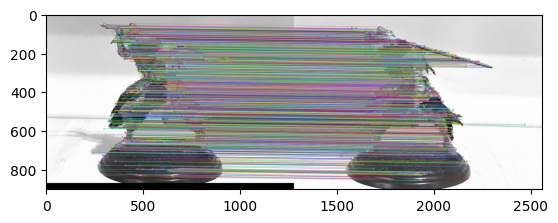

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

image1 = cv.imread(filename = 'img_2.jpg',
                   flags = cv.IMREAD_GRAYSCALE)

image2 = cv.imread(filename = 'img_1.jpg',
                   flags = cv.IMREAD_GRAYSCALE)

AKAZE = cv.AKAZE_create()

keypoints1, descriptors1 = AKAZE.detectAndCompute(image1, None)
keypoints2, descriptors2 = AKAZE.detectAndCompute(image2, None)

FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREE,
                    trees = 5)

search_params = dict(checks = 50)

descriptors1 = np.float32(descriptors1)
descriptors2 = np.float32(descriptors2)

FLANN = cv.FlannBasedMatcher(indexParams = index_params,
                             searchParams = search_params)

matches = FLANN.knnMatch(queryDescriptors = descriptors1,
                         trainDescriptors = descriptors2,
                         k = 2)

ratio_thresh = 0.7

good_matches = []

for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

output = cv.drawMatches(img1 = image1,
                        keypoints1 = keypoints1,
                        img2 = image2,
                        keypoints2 = keypoints2,
                        matches1to2 = good_matches,
                        outImg = None,
                        flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(output)
plt.show()

<h1>Власний матчинг</h1>

додаємо попередню обробку зображення: Зміна контрастності (одне зображення стає контрастнішим, інше – менш контрастним).
Обертання зображення (одне зображення обертається на 20 градусів).

матчінг виконується власною реалізацією.
Відстань між дескрипторами обчислюється через норму L2 (евклідову відстань).
Відбираються пари ключових точок за критерієм Лоу (аналогічно FLANN).

Вручну створювати cv.DMatch() для кожної знайденої відповідності.

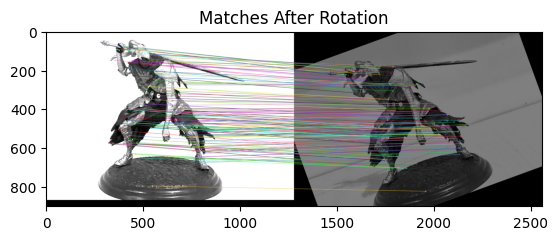

Number of good matches: 144


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

def adjust_contrast(image, factor):
    return np.clip(image * factor, 0, 255).astype(np.uint8)

def custom_match(descriptors1, descriptors2, ratio_thresh=0.7):
    matches = []
    for i, desc1 in enumerate(descriptors1):
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        indices = np.argsort(distances)
        if distances[indices[0]] < ratio_thresh * distances[indices[1]]:
            matches.append((i, indices[0], distances[indices[0]]))
    return matches

def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    return rotated_image

image1 = cv.imread('img_2.jpg', cv.IMREAD_GRAYSCALE)
image2 = cv.imread('img_1.jpg', cv.IMREAD_GRAYSCALE)


distorted_image1 = adjust_contrast(image1, 1.5)
distorted_image2 = adjust_contrast(image2, 0.5)

rotated_image2 = rotate_image(distorted_image2, 20)

AKAZE = cv.AKAZE_create()
keypoints1, descriptors1 = AKAZE.detectAndCompute(distorted_image1, None)
keypoints2, descriptors2 = AKAZE.detectAndCompute(rotated_image2, None)

matches = custom_match(descriptors1, descriptors2)

output_image = cv.drawMatches(
    distorted_image1,
    keypoints1,
    rotated_image2,
    keypoints2,
    [cv.DMatch(m[0], m[1], m[2]) for m in matches],
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.imshow(output_image)
plt.title('Matches After Rotation')
plt.show()

print(f'Number of good matches: {len(matches)}')


Використовує matplotlib для відображення об'єднаного зображення та малювання ліній між ключовими точками.
Самостійно обробляє зсув точок другого зображення, щоб правильно малювати лінії між відповідними точками.

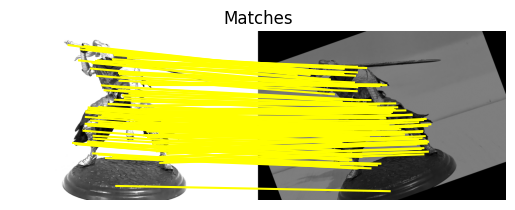

Number of good matches: 144


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv


def adjust_contrast(image, factor):
    return np.clip(image * factor, 0, 255).astype(np.uint8)

def custom_match(descriptors1, descriptors2, ratio_thresh=0.7):
    matches = []
    for i, desc1 in enumerate(descriptors1):
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        indices = np.argsort(distances)
        if distances[indices[0]] < ratio_thresh * distances[indices[1]]:
            matches.append((i, indices[0], distances[indices[0]]))
    return matches

def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    return rotated_image

def visualize_matches(img1, keypoints1, img2, keypoints2, matches):
    if img1.shape[0] != img2.shape[0]:
        img2 = cv.resize(img2, (img2.shape[1], img1.shape[0]))

    combined_image = np.hstack((img1, img2))

    for match in matches:
        (i, j, _) = match
        pt1 = (int(keypoints1[i].pt[0]), int(keypoints1[i].pt[1]))
        pt2 = (int(keypoints2[j].pt[0]) + img1.shape[1], int(keypoints2[j].pt[1]))

        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='yellow')

    plt.imshow(combined_image, cmap='gray')
    plt.title('Matches')
    plt.axis('off')
    plt.show()

image1 = cv.imread('img_2.jpg', cv.IMREAD_GRAYSCALE)
image2 = cv.imread('img_1.jpg', cv.IMREAD_GRAYSCALE)

distorted_image1 = adjust_contrast(image1, 1.5)
distorted_image2 = adjust_contrast(image2, 0.5)

rotated_image2 = rotate_image(distorted_image2, 20)

AKAZE = cv.AKAZE_create()
keypoints1, descriptors1 = AKAZE.detectAndCompute(distorted_image1, None)
keypoints2, descriptors2 = AKAZE.detectAndCompute(rotated_image2, None)

matches = custom_match(descriptors1, descriptors2)
visualize_matches(distorted_image1, keypoints1, rotated_image2, keypoints2, matches)

print(f'Number of good matches: {len(matches)}')


Фільтрація та перевірка даних

У функції custom_match додано перевірку if len(descriptors1) == 0 or len(descriptors2) == 0: return [].
Це запобігає помилкам, якщо немає дескрипторів, що може трапитися, коли detect_keypoints не знаходить жодної ключової точки.
Коригування роботи зображень при візуалізації

Якщо висота img1 і img2 відрізняється, то в новій версії visualize_matches тепер виконує img2 = cv.resize(img2, (img2.shape[1], img1.shape[0])), щоб вони мали однакову висоту.
Це униканє візуальних спотворень під час побудови спільного зображення.
Обробка патчів при створенні дескрипторів

У функції compute_descriptors додано перевірку, щоб уникнути виходу патча за межі зображення.
Раніше програма аварійно завершувалася, якщо x або y були близько до краю зображення.
Виправлено проблему, коли np.array(descriptors, dtype=np.float32) створював порожній масив, якщо всі патчі були відкинуті.
Оптимізація в custom_match

Було виправлено помилку в distances = np.linalg.norm(descriptors2 - desc1, axis=1).
В попередньому варіанті міг виникати конфлікт з розмірами масиву, якщо descriptors2 був порожнім або мав іншу форму.

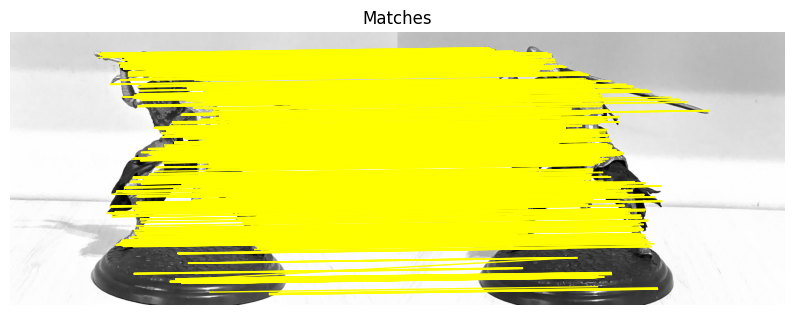

Number of good matches: 2333


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


def build_scale_pyramid(image, num_levels=5, sigma=1.6):
    pyramid = [image]
    for i in range(1, num_levels):
        blurred = cv.GaussianBlur(pyramid[-1], (5, 5), sigma)
        pyramid.append(blurred)
    return pyramid


def detect_keypoints(image):
    hessian = cv.cornerHarris(image, 2, 3, 0.04)
    keypoints = np.argwhere(hessian > 0.01 * hessian.max())
    keypoints = [cv.KeyPoint(float(x[1]), float(x[0]), 10) for x in keypoints]
    return keypoints


def compute_descriptors(image, keypoints, patch_size=16):
    descriptors = []
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])

        if (x - patch_size // 2 < 0 or x + patch_size // 2 >= image.shape[1] or
            y - patch_size // 2 < 0 or y + patch_size // 2 >= image.shape[0]):
            continue

        patch = image[y - patch_size // 2 : y + patch_size // 2,
                      x - patch_size // 2 : x + patch_size // 2]

        gx = cv.Sobel(patch, cv.CV_32F, 1, 0, ksize=3)
        gy = cv.Sobel(patch, cv.CV_32F, 0, 1, ksize=3)

        magnitude = np.sqrt(gx**2 + gy**2)
        angle = np.arctan2(gy, gx)

        descriptor = np.hstack((magnitude.flatten(), angle.flatten()))
        descriptors.append(descriptor)

    return np.array(descriptors, dtype=np.float32)


def custom_match(descriptors1, descriptors2, ratio_thresh=0.75):
    if len(descriptors1) == 0 or len(descriptors2) == 0:
        return []

    matches = []
    for i, desc1 in enumerate(descriptors1):
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        indices = np.argsort(distances)

        if len(indices) > 1 and distances[indices[0]] < ratio_thresh * distances[indices[1]]:
            matches.append((i, indices[0], distances[indices[0]]))

    return matches


def visualize_matches(img1, keypoints1, img2, keypoints2, matches):
    if img1.shape[0] != img2.shape[0]:
        img2 = cv.resize(img2, (img2.shape[1], img1.shape[0]))

    combined_image = np.hstack((img1, img2))

    plt.figure(figsize=(10, 5))
    plt.imshow(combined_image, cmap='gray')

    for match in matches:
        (i, j, _) = match
        pt1 = (int(keypoints1[i].pt[0]), int(keypoints1[i].pt[1]))
        pt2 = (int(keypoints2[j].pt[0]) + img1.shape[1], int(keypoints2[j].pt[1]))

        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='yellow', linewidth=1)

    plt.title('Matches')
    plt.axis('off')
    plt.show()


image1 = cv.imread('img_1.jpg', cv.IMREAD_GRAYSCALE)
image2 = cv.imread('img_2.jpg', cv.IMREAD_GRAYSCALE)

if image1 is None or image2 is None:
    print("Помилка завантаження зображень!")
    exit()


pyramid1 = build_scale_pyramid(image1)
pyramid2 = build_scale_pyramid(image2)

image1 = pyramid1[0]
image2 = pyramid2[0]


keypoints1 = detect_keypoints(image1)
keypoints2 = detect_keypoints(image2)


descriptors1 = compute_descriptors(image1, keypoints1)
descriptors2 = compute_descriptors(image2, keypoints2)

matches = custom_match(descriptors1, descriptors2)

visualize_matches(image1, keypoints1, image2, keypoints2, matches)

print(f'Number of good matches: {len(matches)}')


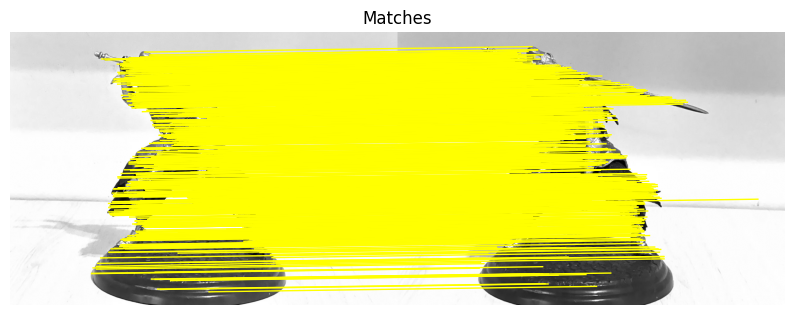

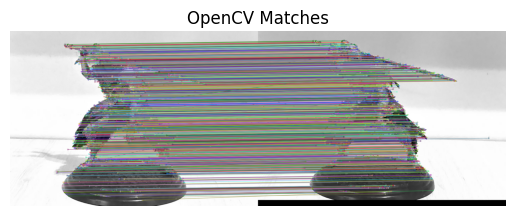

Number of good matches: 999
Number of OpenCV matches: 2234


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


def build_scale_pyramid(image, num_levels=5, sigma=1.6):
    pyramid = [image]
    for i in range(1, num_levels):
        blurred = cv.GaussianBlur(pyramid[-1], (5, 5), sigma)
        pyramid.append(blurred)
    return pyramid


def detect_keypoints(image):
    detector = cv.AKAZE_create()
    keypoints = detector.detect(image, None)
    return keypoints


def compute_descriptors(image, keypoints):
    extractor = cv.AKAZE_create()
    keypoints, descriptors = extractor.compute(image, keypoints)
    return descriptors


def custom_match(descriptors1, descriptors2, ratio_thresh=0.75):
    if len(descriptors1) == 0 or len(descriptors2) == 0:
        return []

    matches = []
    for i, desc1 in enumerate(descriptors1):
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        indices = np.argsort(distances)

        if len(indices) > 1 and distances[indices[0]] < ratio_thresh * distances[indices[1]]:
            matches.append((i, indices[0], distances[indices[0]]))

    return matches


def visualize_matches(img1, keypoints1, img2, keypoints2, matches):
    if img1.shape[0] != img2.shape[0]:
        img2 = cv.resize(img2, (img2.shape[1], img1.shape[0]))

    # Об'єднання зображень
    combined_image = np.hstack((img1, img2))

    plt.figure(figsize=(10, 5))
    plt.imshow(combined_image, cmap='gray')

    for match in matches:
        (i, j, _) = match
        pt1 = (int(keypoints1[i].pt[0]), int(keypoints1[i].pt[1]))
        pt2 = (int(keypoints2[j].pt[0]) + img1.shape[1], int(keypoints2[j].pt[1]))

        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='yellow', linewidth=1)

    plt.title('Matches')
    plt.axis('off')
    plt.show()


def create_distorted_images(image):
    contrast_image = cv.convertScaleAbs(image, alpha=1.5, beta=0)

    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy_image = cv.add(image, noise)

    return contrast_image, noisy_image


image1 = cv.imread('img_1.jpg', cv.IMREAD_GRAYSCALE)
image2 = cv.imread('img_2.jpg', cv.IMREAD_GRAYSCALE)

if image1 is None or image2 is None:
    print("Помилка завантаження зображень!")
    exit()


distorted_image1, distorted_image2 = image1, image2


if distorted_image1.shape != image1.shape:
    distorted_image1 = cv.resize(distorted_image1, (image1.shape[1], image1.shape[0]))

if distorted_image2.shape != image2.shape:
    distorted_image2 = cv.resize(distorted_image2, (image2.shape[1], image2.shape[0]))

distorted_image1 = cv.addWeighted(image1, 0.5, distorted_image1, 0.5, 0)
distorted_image2 = cv.addWeighted(image2, 0.5, distorted_image2, 0.5, 0)


pyramid1 = build_scale_pyramid(distorted_image1)
pyramid2 = build_scale_pyramid(distorted_image2)

image1 = pyramid1[0]
image2 = pyramid2[0]

keypoints1 = detect_keypoints(image1)
keypoints2 = detect_keypoints(image2)


descriptors1 = compute_descriptors(image1, keypoints1)
descriptors2 = compute_descriptors(image2, keypoints2)


matches = custom_match(descriptors1, descriptors2)


visualize_matches(image1, keypoints1, image2, keypoints2, matches)


bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches_cv = bf.match(descriptors1, descriptors2)

img_matches = cv.drawMatches(image1, keypoints1, image2, keypoints2, matches_cv, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.title('OpenCV Matches')
plt.axis('off')
plt.show()

print(f'Number of good matches: {len(matches)}')
print(f'Number of OpenCV matches: {len(matches_cv)}')


зміна custom_match
Порівнює кожен дескриптор першого зображення з кожним дескриптором другого зображення, використовуючи Hamming-дистанцію (оскільки A-KAZE використовує бінарні дескриптори).

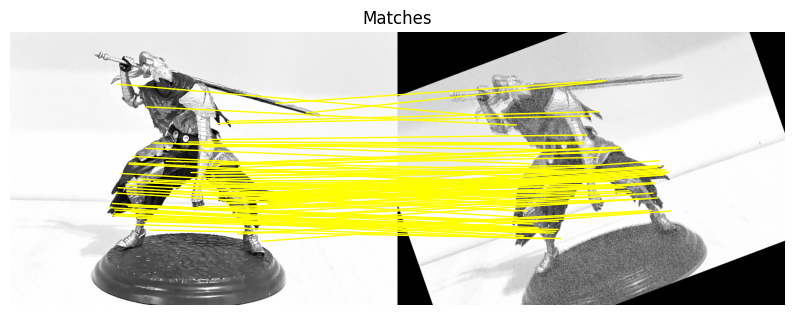

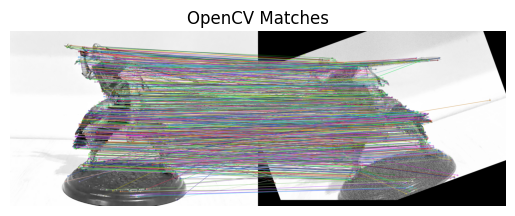

Number of good matches: 105
Number of OpenCV matches: 1292


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


def build_scale_pyramid(image, num_levels=5, sigma=1.6):
    pyramid = [image]
    for i in range(1, num_levels):
        blurred = cv.GaussianBlur(pyramid[-1], (5, 5), sigma)
        pyramid.append(blurred)
    return pyramid


def detect_keypoints(image):
    detector = cv.AKAZE_create()
    keypoints = detector.detect(image, None)
    return keypoints


def compute_descriptors(image, keypoints):
    extractor = cv.AKAZE_create()
    keypoints, descriptors = extractor.compute(image, keypoints)
    return descriptors


def custom_match(descriptors1, descriptors2, ratio_thresh=0.75):
    if len(descriptors1) == 0 or len(descriptors2) == 0:
        return []

    matches = []
    for i, desc1 in enumerate(descriptors1):
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        indices = np.argsort(distances)

        if len(indices) > 1 and distances[indices[0]] < ratio_thresh * distances[indices[1]]:
            matches.append((i, indices[0], distances[indices[0]]))

    return matches


def visualize_matches(img1, keypoints1, img2, keypoints2, matches):
    if img1.shape[0] != img2.shape[0]:
        img2 = cv.resize(img2, (img2.shape[1], img1.shape[0]))

    combined_image = np.hstack((img1, img2))

    plt.figure(figsize=(10, 5))
    plt.imshow(combined_image, cmap='gray')

    for match in matches:
        (i, j, _) = match
        pt1 = (int(keypoints1[i].pt[0]), int(keypoints1[i].pt[1]))
        pt2 = (int(keypoints2[j].pt[0]) + img1.shape[1], int(keypoints2[j].pt[1]))

        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='yellow', linewidth=1)

    plt.title('Matches')
    plt.axis('off')
    plt.show()


def create_distorted_images(image):
    contrast_image = cv.convertScaleAbs(image, alpha=1.5, beta=0)

    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy_image = cv.add(image, noise)

    return contrast_image, noisy_image


image1 = cv.imread('img_1.jpg', cv.IMREAD_GRAYSCALE)
image2 = cv.imread('img_2.jpg', cv.IMREAD_GRAYSCALE)

if image1 is None or image2 is None:
    print("Помилка завантаження зображень!")
    exit()


distorted_image1, distorted_image2 = create_distorted_images(image1)


if distorted_image1.shape != image1.shape:
    distorted_image1 = cv.resize(distorted_image1, (image1.shape[1], image1.shape[0]))

if distorted_image2.shape != image2.shape:
    distorted_image2 = cv.resize(distorted_image2, (image2.shape[1], image2.shape[0]))

distorted_image1 = cv.addWeighted(image1, 0.5, distorted_image1, 0.5, 0)
distorted_image2 = cv.addWeighted(image2, 0.5, distorted_image2, 0.5, 0)


height, width = distorted_image2.shape
center = (width // 2, height // 2)
matrix = cv.getRotationMatrix2D(center, 20, 1.0)
rotated_image2 = cv.warpAffine(distorted_image2, matrix, (width, height))


pyramid1 = build_scale_pyramid(distorted_image1)
pyramid2 = build_scale_pyramid(rotated_image2)

image1 = pyramid1[0]
image2 = pyramid2[0]


keypoints1 = detect_keypoints(image1)
keypoints2 = detect_keypoints(image2)


descriptors1 = compute_descriptors(image1, keypoints1)
descriptors2 = compute_descriptors(image2, keypoints2)


matches = custom_match(descriptors1, descriptors2)


visualize_matches(image1, keypoints1, image2, keypoints2, matches)


bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches_cv = bf.match(descriptors1, descriptors2)


img_matches = cv.drawMatches(image1, keypoints1, image2, keypoints2, matches_cv, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.title('OpenCV Matches')
plt.axis('off')
plt.show()


print(f'Number of good matches: {len(matches)}')
print(f'Number of OpenCV matches: {len(matches_cv)}')


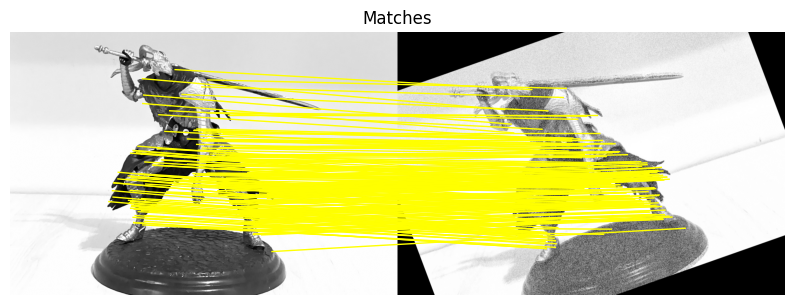

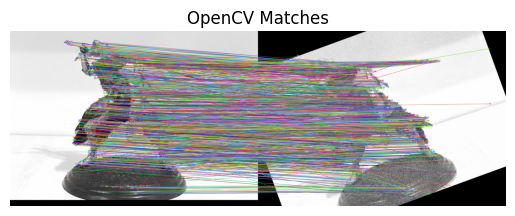

Number of good matches: 209
Number of OpenCV matches: 1353


In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt


def build_scale_pyramid(image, num_levels=5, sigma=1.6):
    pyramid = [image]
    for i in range(1, num_levels):
        blurred = cv.GaussianBlur(pyramid[-1], (5, 5), sigma)
        pyramid.append(blurred)
    return pyramid


def detect_keypoints(image):
    detector = cv.AKAZE_create()
    keypoints = detector.detect(image, None)
    return keypoints


def compute_descriptors(image, keypoints):
    extractor = cv.AKAZE_create()
    keypoints, descriptors = extractor.compute(image, keypoints)
    return descriptors


def custom_match(descriptors1, descriptors2, ratio_thresh=0.75):
    if len(descriptors1) == 0 or len(descriptors2) == 0:
        return []

    matches = []
    for i, desc1 in enumerate(descriptors1):
        distances = np.linalg.norm(descriptors2 - desc1, axis=1)
        indices = np.argsort(distances)

        if len(indices) > 1 and distances[indices[0]] < ratio_thresh * distances[indices[1]]:
            matches.append((i, indices[0], distances[indices[0]]))

    return matches


def visualize_matches(img1, keypoints1, img2, keypoints2, matches):
    if img1.shape[0] != img2.shape[0]:
        img2 = cv.resize(img2, (img2.shape[1], img1.shape[0]))

    combined_image = np.hstack((img1, img2))

    plt.figure(figsize=(10, 5))
    plt.imshow(combined_image, cmap='gray')

    for match in matches:
        (i, j, _) = match
        pt1 = (int(keypoints1[i].pt[0]), int(keypoints1[i].pt[1]))
        pt2 = (int(keypoints2[j].pt[0]) + img1.shape[1], int(keypoints2[j].pt[1]))

        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='yellow', linewidth=1)

    plt.title('Matches')
    plt.axis('off')
    plt.show()


def create_distorted_images(image):
    contrast_image = cv.convertScaleAbs(image, alpha=1.5, beta=0)

    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy_image = cv.add(image, noise)

    return contrast_image, noisy_image


image1 = cv.imread('img_2.jpg', cv.IMREAD_GRAYSCALE)
image2 = cv.imread('img_1.jpg', cv.IMREAD_GRAYSCALE)

if image1 is None or image2 is None:
    print("Помилка завантаження зображень!")
    exit()


distorted_image1, distorted_image2 = create_distorted_images(image1)


if distorted_image1.shape != image1.shape:
    distorted_image1 = cv.resize(distorted_image1, (image1.shape[1], image1.shape[0]))

if distorted_image2.shape != image2.shape:
    distorted_image2 = cv.resize(distorted_image2, (image2.shape[1], image2.shape[0]))

distorted_image1 = cv.addWeighted(image1, 0.5, distorted_image1, 0.5, 0)
distorted_image2 = cv.addWeighted(image2, 0.5, distorted_image2, 0.5, 0)


height, width = distorted_image2.shape
center = (width // 2, height // 2)
matrix = cv.getRotationMatrix2D(center, 20, 1.0)
rotated_image2 = cv.warpAffine(distorted_image2, matrix, (width, height))


pyramid1 = build_scale_pyramid(distorted_image1)
pyramid2 = build_scale_pyramid(rotated_image2)

image1 = pyramid1[0]
image2 = pyramid2[0]


keypoints1 = detect_keypoints(image1)
keypoints2 = detect_keypoints(image2)


descriptors1 = compute_descriptors(image1, keypoints1)
descriptors2 = compute_descriptors(image2, keypoints2)


matches = custom_match(descriptors1, descriptors2)


visualize_matches(image1, keypoints1, image2, keypoints2, matches)


bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches_cv = bf.match(descriptors1, descriptors2)


img_matches = cv.drawMatches(image1, keypoints1, image2, keypoints2, matches_cv, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_matches)
plt.title('OpenCV Matches')
plt.axis('off')
plt.show()


print(f'Number of good matches: {len(matches)}')
print(f'Number of OpenCV matches: {len(matches_cv)}')


new